# Environment

## Libraries

In [17]:
import os, subprocess, json, requests, getpass, urllib.parse, sys, pathlib, string, numpy as np, seaborn as sns, \
pandas as pd, matplotlib.pyplot as plt, google.cloud.bigquery as bigquery, tensorflow as tf,  string, spacy

from bs4 import BeautifulSoup
from astropy.visualization import hist as astro_hist
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn

## Specifying the Working Directory

In [18]:
workingdir=os.getcwd()
d=[d for d in os.listdir(workingdir)]
n=0
while not set(['notebook']).issubset(set(d)):
    workingdir=str(pathlib.Path(workingdir).parents[0])

    d=[d for d in os.listdir(str(workingdir))]
    n+=1
    if n>5:
        break
sys.path.insert(0, workingdir)
os.chdir(workingdir)

## Dealing with Warnings

In [19]:
pd.set_option('mode.chained_assignment', None)

## Function Definitions

In [20]:
def decode_html(input_str: str, body: str = '') -> str:
    soup = BeautifulSoup(input_str, 'html.parser')
    
    if len(body) == 0:
        output = soup.text
        return output
    
    html_elements = soup.find_all(body)
    output = ' '.join(html_elements)
    return output

In [21]:
def nlp(input_list: list, spacy_obj) -> list:
    doc = spacy_obj(input_list)
    stopwords = list(string.punctuation + string.digits) + ['-pron-']
    output = [token.lemma_.lower() for token in doc if not token.is_stop and token.lemma_.lower() not in stopwords]
    return output

In [22]:
def tokenizer(input_list: list) -> list:
    spacy_obj = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    doc = spacy_obj(input_list)
    stopwords = list(string.punctuation + string.digits) + ['-pron-']
    output = [token.lemma_.lower() for token in doc if not token.is_stop and token.lemma_.lower() not in stopwords]
    return output

In [23]:
def preprocess(input_str: str) -> list:
        spacy_object = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
        
        try:
            step_1 = decode_html(input_str)
            step_2 = nlp(step_1, spacy_object)
            return step_2
        except TypeError:
            return ''

In [24]:
def split_tags(tags: str) -> list:
    return tags.split('|')

In [25]:
def create_label(tags, mapping):
    for tag in tags:
        if tag in mapping.keys():
            return mapping[tag]
        else:
            return 0

## Specifying GCP-Related Variables 

In [26]:
os.environ['PROJECT_ID'] = subprocess.run('gcloud config list project --format "value(core.project)"', 
                                          shell=True, check=True, stdout=subprocess.PIPE) \
                                            .stdout.decode().replace('\n', '').replace('\r', '')
print(os.environ['PROJECT_ID'])

axa-ch-machine-learning-dev


In [27]:
os.environ['BUCKET_NAME']='axa-ch-machine-learning-poc-dev'

In [28]:
try:
    tmp=os.environ['PROJECT_ID']
except:
    print('Env variable PROJECT not defined!') 

try:
    tmp=os.environ['BUCKET_NAME']
except:
    print('Env variable BUCKET_NAME not defined!') 
    
try:    
    tmp=os.environ['GOOGLE_APPLICATION_CREDENTIALS']
except:
    print('Env variable GOOGLE_APPLICATION_CREDENTIALS not defined!') 

try:
    tmp=os.environ['REQUESTS_CA_BUNDLE']
except:
    print('Env variable REQUESTS_CA_BUNDLE not defined!') 

try:
    tmp=os.environ['AXA_CH_CA_BUNDLE']
except:
    print('Env variable AXA_CA_CA_BUNDLE not defined!') 

## Does the Connection Work?

In [29]:
use_proxy='Y'
proxies = {
    'https': os.environ['HTTPS_PROXY'],    
    'http': os.environ['HTTP_PROXY']
}  

In [30]:
list_url=['https://www.google.com',
          'http://www.google.com',
          'https://www.example.com',
          'http://www.example.com',
          'https://github.com/j0hannes/cutter-ng']

for url in list_url:
    print('')
    print('trying to access:'+url)
    try:
        if use_proxy=='N':
            r = requests.get(url)
        else:
            # SSL deactivated
            #r = requests.get(url,proxies=proxies,verify=False)
            r = requests.get(url,proxies=proxies,verify=True)
            
        if r.status_code == requests.codes.ok:
            print('=>OK',r.headers['content-type'])
        else:
            # 407 Proxy Authentication Required
            print ('=> ??', r.status_code)
    except Exception as inst:
        print('=>FAILED')
        print(type(inst))    # the exception instance
        print(inst.args)     # arguments stored in .args
        print(inst)


trying to access:https://www.google.com
=>OK text/html; charset=ISO-8859-1

trying to access:http://www.google.com
=>OK text/html; charset=ISO-8859-1

trying to access:https://www.example.com
=>OK text/html; charset=UTF-8

trying to access:http://www.example.com
=>OK text/html; charset=UTF-8

trying to access:https://github.com/j0hannes/cutter-ng
=>OK text/html; charset=utf-8


# Loading Data

In [31]:
query = """SELECT
 *
FROM
  `nlp_text_classification.stackoverflow_posts_complete`
WHERE
  tags <> ''
LIMIT 
  1000
"""

In [32]:
client = bigquery.Client()
df = client.query(query).to_dataframe()

# Preprocessing

In [33]:
df['body_new'] = df['body'].apply(preprocess)
df['tags_new'] = df['tags'].apply(split_tags)

# TF-IDF

## Distribution of the Document Size

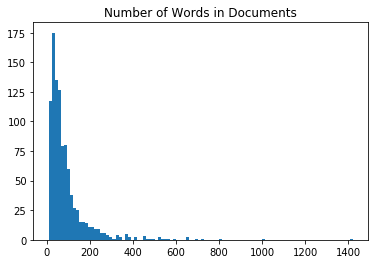

In [34]:
%matplotlib inline
# Plot histogram of text lengths
text_lengths = [len(x) for x in df['body_new']]
plt.hist(text_lengths, bins=100)
plt.title('Number of Words in Documents')
plt.show()

## TF-IDF

In [36]:
max_features = 1000

In [37]:
tfidf = sklearn.feature_extraction.text.TfidfVectorizer(max_features=max_features)
corpus = df['body_new'].apply(' '.join).tolist()
posts_tfidf = tfidf.fit_transform(corpus).toarray()

## Creating Labels

In [28]:
query = """SELECT
 *
FROM
  `bigquery-public-data.stackoverflow.tags`
ORDER BY
  count desc"""
df_tags = client.query(query).to_dataframe()

In [29]:
df_tags.head()

,id,tag_name,count,excerpt_post_id,wiki_post_id
0,3,javascript,1862833,3624960.0,3607052.0
1,17,java,1581854,3624966.0,3607018.0
2,9,c#,1339575,3624962.0,3607007.0
3,5,php,1303327,3624936.0,3607050.0
4,16,python,1236812,3624965.0,3607014.0


In [53]:
mapping = {}
for record in range(0, 10):
    mapping[df_tags['tag_name'].iloc[record]] = record + 1
mapping['unknown'] = 0

In [54]:
df['label'] = df['tags_new'].apply(lambda array: create_label(array, mapping))

## Training and Testing Sets

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(posts_tfidf, df['label'], test_size=0.2, random_state=0)

## Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

## Random Forest: Grid Search

In [59]:
from sklearn.model_selection import GridSearchCV

In [63]:
classifier = RandomForestClassifier()
param = {'n_estimators': [10, 50, 300],
        'max_depth': [30, 60, 90]}
gs = GridSearchCV(classifier, param, cv=5, n_jobs=-1)
gs_fit = gs.fit(X_train, y_train)

C:\Users\C311723\.conda\envs\env_nlp_text_class\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [68]:
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.975094,0.055179,0.015559,0.002240,60,50,"{'max_depth': 60, 'n_estimators': 50}",0.490909,0.512346,0.522013,0.503185,0.528662,0.51125,0.013449,1
5,5.851777,0.235453,0.079182,0.004575,60,300,"{'max_depth': 60, 'n_estimators': 300}",0.503030,0.506173,0.515723,0.509554,0.522293,0.51125,0.006901,1
7,1.535741,0.102911,0.021541,0.008888,90,50,"{'max_depth': 90, 'n_estimators': 50}",0.496970,0.500000,0.528302,0.515924,0.509554,0.51000,0.011348,3
8,7.165136,0.770222,0.070816,0.014741,90,300,"{'max_depth': 90, 'n_estimators': 300}",0.496970,0.500000,0.515723,0.509554,0.522293,0.50875,0.009482,4
3,0.203635,0.013532,0.004985,0.000893,60,10,"{'max_depth': 60, 'n_estimators': 10}",0.490909,0.512346,0.503145,0.522293,0.503185,0.50625,0.010504,5


## Performance Evaluation

In [36]:
y_pred = classifier.predict(X_test)

In [37]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[92  5  2  0  1  0  1  0  0  0  0]
 [13  8  0  0  0  0  0  0  0  0  0]
 [ 6  0  3  0  0  0  1  0  0  0  0]
 [ 8  0  0  0  0  0  0  0  0  0  0]
 [ 8  0  0  0  7  0  0  0  0  0  0]
 [ 8  0  0  0  0  0  0  0  0  0  0]
 [ 5  0  0  0  0  0  8  0  0  0  0]
 [ 3  1  0  0  1  0  0  0  0  0  0]
 [ 8  0  0  0  0  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0  0  0  0]
 [ 7  0  0  0  0  0  0  0  0  0  0]]


C:\Users\C311723\.conda\envs\env_nlp_text_class\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.57      0.91      0.70       101
           1       0.57      0.38      0.46        21
           2       0.60      0.30      0.40        10
           3       0.00      0.00      0.00         8
           4       0.78      0.47      0.58        15
           5       0.00      0.00      0.00         8
           6       0.80      0.62      0.70        13
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         7

    accuracy                           0.59       200
   macro avg       0.30      0.24      0.26       200
weighted avg       0.49      0.59      0.51       200

0.59


## Multi-Label Classification

Most traditional learning algorithms are developed for single-label classification problems. Therefore a lot of approaches in the literature transform the multi-label problem into multiple single-label problems, so that the existing single-label algorithms can be used

https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff

# N-Grams

In [47]:
ngram_vect = sklearn.feature_extraction.text.CountVectorizer(ngram_range=(2,2))
corpus = df['body_new'].apply(' '.join)
ngram_counts = tfidf.fit_transform(corpus)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(ngram_counts, df['label'], test_size=0.2, random_state=0)

In [71]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train) 

C:\Users\C311723\.conda\envs\env_nlp_text_class\lib\site-packages\sklearn\utils\fixes.py:192: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return X != X
C:\Users\C311723\.conda\envs\env_nlp_text_class\lib\site-packages\sklearn\utils\fixes.py:192: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return X != X


AttributeError: 'bool' object has no attribute 'any'

In [50]:
y_pred = classifier.predict(X_test)

In [51]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[100   0   1   0   0   0   0   0   0   0   0]
 [ 21   0   0   0   0   0   0   0   0   0   0]
 [  9   0   1   0   0   0   0   0   0   0   0]
 [  8   0   0   0   0   0   0   0   0   0   0]
 [ 14   1   0   0   0   0   0   0   0   0   0]
 [  8   0   0   0   0   0   0   0   0   0   0]
 [ 11   0   1   0   0   0   1   0   0   0   0]
 [  5   0   0   0   0   0   0   0   0   0   0]
 [  8   0   0   0   0   0   0   0   0   0   0]
 [  4   0   0   0   0   0   0   0   0   0   0]
 [  7   0   0   0   0   0   0   0   0   0   0]]


C:\Users\C311723\.conda\envs\env_nlp_text_class\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.51      0.99      0.68       101
           1       0.00      0.00      0.00        21
           2       0.33      0.10      0.15        10
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        15
           5       0.00      0.00      0.00         8
           6       1.00      0.08      0.14        13
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         7

    accuracy                           0.51       200
   macro avg       0.17      0.11      0.09       200
weighted avg       0.34      0.51      0.36       200

0.51
